In [4]:
!nvidia-smi

Wed Dec 28 03:45:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   42C    P0    83W / 300W |   3575MiB / 32505MiB |     70%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [5]:
import sys
sys.path.append('../')

In [6]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from matplotlib import colors

from skimage.transform import resize

from utils.metrics import classification_result

In [7]:
hashs =["2022-07-17_08-42-37", "2022-07-17_08-08-44", "2022-07-17_07-35-01", "2022-07-17_07-00-28", "2022-07-17_06-26-33",
        "2022-07-17_05-52-44", "2022-07-17_05-18-44", "2022-07-17_04-45-35", "2022-07-17_04-11-44", "2022-07-17_03-37-31"]

In [8]:
gpus = ['3']
server = 'dgx'

In [9]:
result_total = dict()

In [10]:
os.listdir('../checkpoints')

['pet-swa', 'pet-supmoco_finetune_demo', 'pet', 'pet-supmoco']

In [63]:
for hash in hashs:
    
    print(hash)
    
    config = edict()
    config.server = server
    config.gpus = gpus
    local_rank = 0

    config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/ckpt.last.pth.tar')
    finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/configs.json')
    with open(finetune_config, 'rb') as fb:
        finetune_config = json.load(fb)

    finetune_config_names = [
        # data_parser
        'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
        'image_size', 'small_kernel', 'random_state',
        'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
        # model_parser
        'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
        'arch', 'no_max_pool',
        # train
        'batch_size',
        # moco / supmoco
        'alphas',
        # others
        'task', 'projector_dim'
    ]
    
    for name in finetune_config_names:
        if name in finetune_config.keys():
            setattr(config, name, finetune_config[name])
            
    set_gpu(config)

    np.random.seed(config.random_state)
    torch.manual_seed(config.random_state)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.allow_tf32 = True
    torch.cuda.set_device(local_rank)

    # Networks
    if config.backbone_type == 'densenet':
        backbone = DenseNetBackbone(in_channels=1,
                                    init_features=config.init_features,
                                    growth_rate=config.growth_rate,
                                    block_config=config.block_config,
                                    bn_size=config.bn_size,
                                    dropout_rate=config.dropout_rate,
                                    semi=False)
        activation = True
    elif config.backbone_type == 'resnet':
        backbone = build_resnet_backbone(arch=config.arch,
                                         no_max_pool=config.no_max_pool,
                                         in_channels=1,
                                         semi=False)
        activation = False
    else:
        raise NotImplementedError

    if config.small_kernel:
        backbone._fix_first_conv()

    if config.crop:
        out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
    else:
        out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
    classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

    backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
    classifier.load_weights_from_checkpoint(path=config.finetune_file, key='classifier')

    backbone.to(local_rank)
    classifier.to(local_rank)
    
    # load finetune data
    data_processor = BrainProcessor(root=config.root,
                                    data_info=config.data_info,
                                    data_type=config.data_type,
                                    mci_only=config.mci_only,
                                    random_state=config.random_state)
    datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

    # intensity normalization
    assert config.intensity in [None, 'scale', 'minmax']
    mean_std, min_max = (None, None), (None, None)
    if config.intensity is None:
        pass
    elif config.intensity == 'scale':
        pass
    elif config.intensity == 'minmax':
        with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
            minmax_stats = pickle.load(fb)
            min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
    else:
        raise NotImplementedError

    train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                      intensity=config.intensity,
                                                      min_max=min_max,
                                                      crop_size=config.crop_size,
                                                      rotate=config.rotate,
                                                      flip=config.flip,
                                                      affine=config.affine,
                                                      blur_std=config.blur_std,
                                                      prob=config.prob)

    train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
    test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

    train_loader = DataLoader(dataset=train_set, batch_size=config.batch_size, drop_last=False)
    test_loader = DataLoader(dataset=test_set, batch_size=config.batch_size, drop_last=False)
    
    y_true, y_pred = [], []
    for i, batch in enumerate(test_loader):

        x = batch['x'].float().to(local_rank)
        y = batch['y'].to(local_rank)
        logits = classifier(backbone(x))

        y_true.append(y.long().cpu().numpy())
        y_pred.append(logits.detach().cpu().numpy())

    # accuracy and macro f1 score
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_pred = torch.tensor(y_pred).softmax(1).numpy()

    clf_result = classification_result(y_true=y_true,
                                       y_pred=y_pred,
                                       adjusted=True)
    
    result_total[config.random_state] = dict()
    result_total[config.random_state]['y_true'] = y_true
    result_total[config.random_state]['y_pred'] = y_pred
    result_total[config.random_state]['clf_result'] = clf_result

('2022-07-02_08-00-31', '2022-07-03_13-41-32')
('2022-07-02_08-00-57', '2022-07-03_13-37-29')
('2022-07-02_09-38-52', '2022-07-03_13-33-23')
('2022-07-02_09-40-42', '2022-07-03_13-29-10')
('2022-07-02_11-17-38', '2022-07-03_13-25-05')
('2022-07-02_11-20-21', '2022-07-03_13-21-00')
('2022-07-02_17-15-14', '2022-07-03_13-16-54')
('2022-07-02_17-15-34', '2022-07-03_13-12-44')
('2022-07-02_18-53-46', '2022-07-03_13-08-35')
('2022-07-02_18-54-27', '2022-07-03_13-04-32')


In [67]:
y_true_total = []
y_pred_total = []
for random_state, result in result_total.items():
    if random_state not in [2027, 2031]:
        y_true_total.append(result['y_true'])
        y_pred_total.append(result['y_pred'])
y_true_total = np.concatenate(y_true_total)
y_pred_total = np.concatenate(y_pred_total)

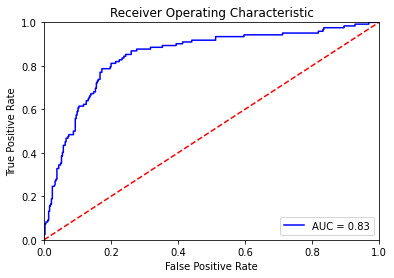

In [68]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(y_true_total, y_pred_total[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % clf_result['auroc'])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [70]:
with open('smoco_result.pkl', 'wb') as f:
    pickle.dump(result_total, f)